In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root="/content/sample_data",
                                                  train=True,
                                                  download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(root="/content/sample_data",
                                                 train=False,
                                                 download=True,
                                                 transform=transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 203kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.78MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 11.3MB/s]


In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)


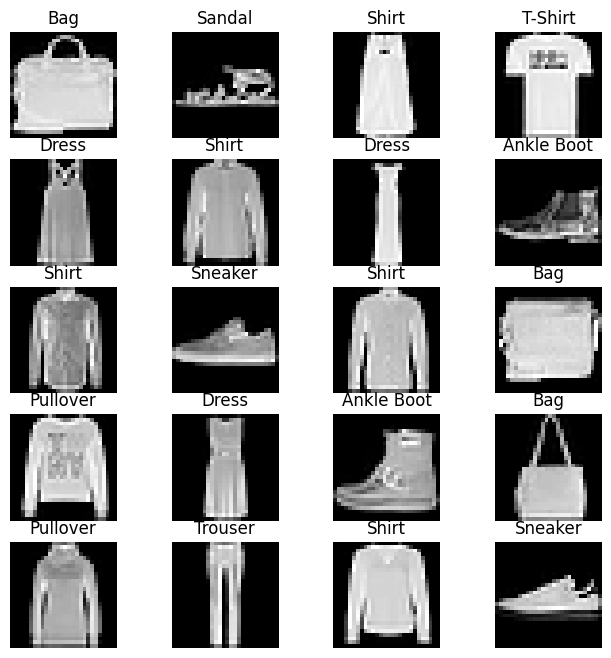

In [6]:
labels_map = {0:'T-Shirt',1:'Trouser',2:'Pullover',
              3: 'Dress', 4:'Coat', 5:'Sandal',
              6: 'Shirt', 7: 'Sneaker', 8:'Bag',9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))
col = 4;
row = 5;
for i in range(1,col*row+1):
  img_xy = np.random.randint(len(train_dataset))
  img = train_dataset[img_xy][0][0,:,:]
  fig.add_subplot(row,col,i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis("off")
  plt.imshow(img,cmap='gray')
plt.show()

In [8]:
class FashionDNN(nn.Module):
  def __init__(self):
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    self.drop = nn.Dropout(0.25)
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data):
    out = input_data.view(-1,784)
    out = F.relu(self.fc1(out))
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [17]:
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [18]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          labels_list.append(labels)
          test = Variable(images.view(100, 1, 28, 28))
          outputs = model(test)
          predictions = torch.max(outputs, 1)[1].to(device)
          predictions_list.append(predictions)
          correct += (predictions == labels).sum()
          total += len(labels)

      accuracy = correct * 100/total
      loss_list.append(loss.data)
      iteration_list.append(loss.data)
      accuracy_list.append(accuracy)
    if not (count%500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%".format(count,loss.data,accuracy))

Iteration : 500, Loss : 0.5885317325592041, Accuracy : 83.33999633789062%
Iteration : 1000, Loss : 0.43888619542121887, Accuracy : 84.37999725341797%
Iteration : 1500, Loss : 0.31155502796173096, Accuracy : 84.57999420166016%
Iteration : 2000, Loss : 0.33299311995506287, Accuracy : 85.54999542236328%
Iteration : 2500, Loss : 0.2833312153816223, Accuracy : 86.37999725341797%
Iteration : 3000, Loss : 0.30242329835891724, Accuracy : 86.41999816894531%


In [24]:
# CNN 생성
class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32,
                  kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size = 2, stride = 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64,
                  kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10)

  def forward(self,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0),-1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out

In [25]:
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [26]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          labels_list.append(labels)
          test = Variable(images.view(100, 1, 28, 28))
          outputs = model(test)
          predictions = torch.max(outputs, 1)[1].to(device)
          predictions_list.append(predictions)
          correct += (predictions == labels).sum()
          total += len(labels)

      accuracy = correct * 100/total
      loss_list.append(loss.data)
      iteration_list.append(loss.data)
      accuracy_list.append(accuracy)
    if not (count%500):
      print("Iteration : {}, Loss : {}, Accuracy : {}%".format(count,loss.data,accuracy))

Iteration : 500, Loss : 0.4551428258419037, Accuracy : 87.66999816894531%
Iteration : 1000, Loss : 0.32626286149024963, Accuracy : 88.0999984741211%
Iteration : 1500, Loss : 0.34484872221946716, Accuracy : 88.00999450683594%
Iteration : 2000, Loss : 0.2086794078350067, Accuracy : 89.25%
Iteration : 2500, Loss : 0.14014536142349243, Accuracy : 90.0999984741211%
Iteration : 3000, Loss : 0.16668982803821564, Accuracy : 90.56999969482422%
